In [21]:
import pandas as pd

In [22]:
from calculate_alignment import calculate_distance_score

In [23]:
ORGANISM_NAMES = [
    "cat",
    "cattle",
    "mouse",
    "rat",
    "wolf",
    "sheep",
]

In [24]:
ORGANISM_FILES = [f"data/{name}.txt" for name in ORGANISM_NAMES]

# Gzip

In [25]:
# for each of the organism pairs, calculate the alignment score
# only on lowercase triangular matrix


def fill_distance_matrix(method: str = "gzip") -> pd.DataFrame:
    """Fill the similarity matrix with the alignment scores.

    Args:
        method (str, optional): The method to use for calculating the alignment score. Defaults to "gzip".

    Returns:
        pd.DataFrame: The similarity matrix.
    """
    df = pd.DataFrame(index=ORGANISM_NAMES, columns=ORGANISM_NAMES)
    # note that upper triangular values remain NaN
    # but matrix is symmetric!
    # still, we do not fill them for clarity
    for i in range(len(ORGANISM_NAMES)):
        for j in range(len(ORGANISM_NAMES)):
            name1 = ORGANISM_NAMES[i]
            name2 = ORGANISM_NAMES[j]
            # skip diagonal and upper triangular matrix
            if i == j:
                df.loc[name1, name2] = 0.
            if i >= j:
                continue
            result = calculate_distance_score(
                file_a=ORGANISM_FILES[i], file_b=ORGANISM_FILES[j], method=method
            )
            df.loc[name2, name1] = result
    return df

In [26]:
df_gzip = fill_distance_matrix(method="gzip")
df_gzip

,cat,cattle,mouse,rat,wolf,sheep
cat,0.0,NaN,NaN,NaN,NaN,NaN
cattle,0.891014,0.0,NaN,NaN,NaN,NaN
mouse,0.907352,0.911593,0.0,NaN,NaN,NaN
rat,0.902371,0.899739,0.832052,0.0,NaN,NaN
wolf,0.867297,0.889939,0.904706,0.900965,0.0,NaN
sheep,0.891014,0.784944,0.903954,0.894968,0.892892,0.0


In [27]:
df_7zip = fill_distance_matrix(method="7zip")
df_7zip

,cat,cattle,mouse,rat,wolf,sheep
cat,0.0,NaN,NaN,NaN,NaN,NaN
cattle,0.620084,0.0,NaN,NaN,NaN,NaN
mouse,0.761506,0.771693,0.0,NaN,NaN,NaN
rat,0.743096,0.763269,0.515718,0.0,NaN,NaN
wolf,0.583887,0.651163,0.76412,0.746678,0.0,NaN
sheep,0.654393,0.433978,0.726661,0.727502,0.655316,0.0


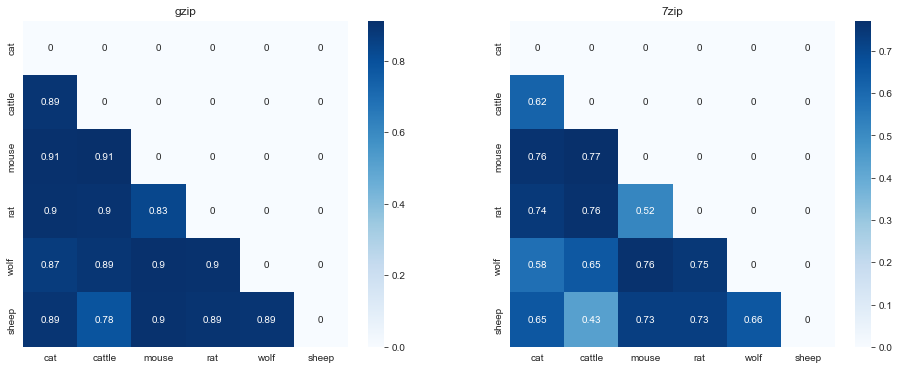

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(df_gzip.fillna(0), annot=True, ax=ax[0], cmap="Blues")
ax[0].set_title("gzip")

sns.heatmap(df_7zip.fillna(0), annot=True, ax=ax[1], cmap="Blues")
ax[1].set_title("7zip");


In [29]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, _DistanceMatrix

def create_distance_tree(df: pd.DataFrame) -> DistanceTreeConstructor:
    """Create a distance tree from a similarity matrix.

    Args:
        df (pd.DataFrame): The similarity matrix.

    Returns:
        DistanceTreeConstructor: The distance tree.
    """
    # convert to distance matrix
    #distance_matrix = df.applymap(lambda x: 1 - x)
    distance_matrix = df
    names = df.columns.values.tolist()
    distance_val = distance_matrix.values.tolist()

    distance_val = [[ subelt for subelt in elt if str(subelt) != "nan" ] for elt in distance_val]
    distance_matrix = _DistanceMatrix(names, distance_val)

    # create the constructor
    constructor = DistanceTreeConstructor()
    # Construct the phlyogenetic tree using UPGMA algorithm
    neighbor_tree = constructor.nj(distance_matrix)
    return neighbor_tree


ModuleNotFoundError: No module named 'Bio'

In [ ]:
from Bio import Phylo
# draw trees for gzip and 7zip
def get_label(leaf):
    if leaf.name[:5] == "Inner":
        return ""
    return leaf.name

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
gzipTree = create_distance_tree(df_gzip)
Phylo.draw(gzipTree, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), axes=ax[0], do_show= False)
ax[0].set_title("gzip");

sev_zipTree = create_distance_tree(df_7zip)
Phylo.draw(sev_zipTree, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), axes=ax[1], do_show= False)
ax[1].set_title("7zip");

plt.savefig("phylogenetic_tree.png")